<a href="https://colab.research.google.com/github/cu-applied-math/appm-4600-numerics/blob/main/Labs/Lab09_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 9: Regression and basic (discrete) approximation theory



### Learning objectives
- Understand an implementation of $\ell_p$ regression (for $p=2$) and have some basic idea for $p=1$ and $p=\infty$
- See that we need to choose a basis
- Compare different loss functions for different types of error models
- Explore on real data, making real decisions (what degree of polynomial? etc.)
- If there's time, look at Total Least Squares / ODR

### Tasks
0. Skim the bakground reading below, and then look at the `lp_regression` code below which we have implemented for you. Try to understand as much as possible what it is doing
1. For the 5 uses cases (b), (c), (d), (e), we have setup different types of "error" in the response variables $y$. For each use case:
    - use the `lp_regression` code to try regression for $p=1$, $p=2$ and $p=\infty$ and decide which one is most appropriate; or for (e), compare weighted and unweighted regression
2. Find your own dataset and do regression on it, deciding on a few things (like which loss function, whether to do a log transform, etc.)
3. (Optional) look at TLS/ODR

### Deliverables

Turn in a single PDF with the following items:
- Turn in plots for 1(b), 1(c), 1(d) and 1(e) along with a sentence or two for each about your findings
- If you get to part 2 (your own real world dataset), then turn in a plot for that too, but it's not required

APPM 4600. Copyright Department of Applied Mathematics, University of Colorado Boulder. Released under a BSD 3-clause licens

In [ ]:
import numpy as np
import scipy.optimize
from numpy.polynomial import Polynomial, Chebyshev, Legendre
from numpy.polynomial import polynomial as P
from matplotlib import pyplot as plt

**Background**

For notation, let $X$ be a $m\times n$ matrix. All these formulations allow weights but we'll skip the details in the interest of time.

The $p=2$ case should already be familiar. The other cases you can skim but don't feel obligated to understand them in depth.

#### **Least squares**

For $p=2$, we solve
$$\min_{\vec{a}} \|X\vec{a} - \vec{y}\|_2^2$$
where $X$ is the Vandermonde matrix in the appropriate basis. Below, we chose a good basis: the Chebyshev basis. By default this basis is best for the interval $[-1,1]$ so if our $x$ data is on an interval [left,right] then we transform the data to $[-1,1]$. Once we have the coefficients $\vec{a}$, we then attach them to the basis elements to get our polynomial. Python's packages do this for us.  To actually find $\vec{a}$, we are conceptially solving the **normal equations** $X^\top X \vec{a} = X^\top \vec{y}$. Programming wise, we call `np.linalg.lstsq(X,y)` which does the solve in a stable way (which we will learn about later this semester).

#### **Least absolute deviation** aka $\ell_1$

For $p=1$, we solve
$$\min_{\vec{a}\in\mathbb{R}^n} \|X\vec{a}-\vec{y}\|_1$$
This can be cast as a **linear program** and solved by [`scipy.optimize.linprog`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html) but first we need to recast it in a standard form (see the documentation of `linprog`). We'll introduce a new variable $\vec{z}\in\mathbb{R}^m$ and we will solve
$$\min_{\vec{a},\vec{z}} \sum_i z_i,\quad\text{s.t.}|X\vec{a}-\vec{y}| \le \vec{z}.$$
We can write these $m$ nonlinear constraints as $2m$ linear constraints
$$X\vec{a}-\vec{y} \le \vec{z},\quad\text{and}\quad -\left(X\vec{a}-\vec{y}\right) \le \vec{z}.$$

We stack $a$ and $z$ into a big vector $\vec{u}=\begin{bmatrix}\vec{a}\\ \vec{z}\end{bmatrix}\in\mathbb{R}^{n+m}$ and let $\vec{c}=\begin{bmatrix}\vec{0}\\ \vec{1}\end{bmatrix}\in\mathbb{R}^{n+m}$.

Then define
$$A_{ub}=\begin{bmatrix}X&-I\\-X&-I\end{bmatrix}, \quad\text{and}\quad b_{ub} = \begin{bmatrix}y \\ -y \end{bmatrix}$$
so that our problem is now
$$\min_{\vec{u}\in\mathbb{R}^{n+m}} \vec{c}^\top \vec{u}$$
subject to
$$A_{ub} \vec{u} \le b_{ub}$$
and then we extract $\vec{a}$ from the first $n$ entries of $\vec{u}$.

#### **Minimax** aka $\ell_\infty$

For $p=\infty$, we won't go into full details but we generally follow a similar approach to the $p=1$ case, only instead of having $\vec{z}\in\mathbb{R}^m$ and setting $|X\vec{a}-\vec{y}|\le \vec{z}$, we instead have $z\in\mathbb{R}$ a scalar, and have $|X\vec{a}-\vec{y}|\le z\vec{1}$, and $\vec{c}=\begin{bmatrix}\vec{0}\\ 1\end{bmatrix}\in\mathbb{R}^{n+1}$, and
$$A_{ub}=\begin{bmatrix}X&-\vec{1}\\-X&-\vec{1}\end{bmatrix}$$
with $b_{ub}$ the same as in the $p=1$ case.

Below is our `lp_regression` function we'll use

In [ ]:
def lp_regression( x, y, deg, p=2, weights=None, debug=False ):
    """ Does lp regression,
    min_{a} || X a - y ||_p  where X is the Vandermonde matrix
    associate with a "deg" degree polynomial representation
    with coefficients a.  p should be 1, 2 or 'inf' (or np.inf)

    The inputs are the nodes x (a 1D vector) from which this code will
    automatically build X; and the response values y.

    Returns a polynomial object (in some polynomial basis that
    is chosen for good stability properties)
    """
    # Step 0: if p=2, this is already done for us
    if p == 2 and not debug:
        myPolynomial = Chebyshev.fit(x,y,deg=deg,w=weights)
        return myPolynomial

    # Step 1: choose a basis and find the corresponding Vandermonde matrix X
    left, right = x.min(), x.max()
    # Make a transformation into the domain (-1,1)
    ln = (right-left)
    offset = -(left + right)/ln
    scale  = 2/ln
    # Let's use a Chebyshev basis, and map the data to its domain (of [-1,1])
    X = np.polynomial.chebyshev.chebvander(offset + scale * x,deg)
    m = X.shape[0]

    # Step 2: solve for the coefficients "a"
    if weights is None:
        weights = np.ones((m,1))
    else:
        if weights.min() < 0: raise ValueError('Weights must be nonnegative')
        weights = weights.reshape((m,1)) # insist it is a column vector
    if p == 2:
        a = np.linalg.lstsq( np.sqrt(weights)*X, np.sqrt(weights)*y.reshape((m,1)), rcond=None )[0]
    elif p == 1:
        A_ub = np.hstack( (np.vstack( (X,-X)), np.vstack((-np.eye(m),-np.eye(m)))) )
        b_ub = np.concatenate((y,-y))
        c    = np.concatenate((np.zeros(deg+1), weights.ravel() ))
        out  = scipy.optimize.linprog(c,A_ub,b_ub,bounds=(None,None)) # solve the linear program
        a    = out.x[:deg+1]
    elif ( type(p) is str and p.lower()=='inf' ) or (np.isinf(p)):
        A_ub = np.hstack( (np.vstack( (X,-X)), np.vstack((-1/weights,-1/weights))) )
        b_ub = np.concatenate((y,-y))
        c    = np.concatenate((np.zeros(deg+1), np.ones(1)))
        out  = scipy.optimize.linprog(c,A_ub,b_ub,bounds=(None,None)) # solve the linear program
        a    = out.x[:deg+1]

    myPolynomial = Chebyshev(a.ravel(),domain=(left,right))
    if debug:
        return myPolynomial, a.ravel(), X, lambda coeffs: Chebyshev(coeffs.ravel(),domain=(left,right))
    return myPolynomial


## Part 1
Different types of loss functions for regression

We will create the data ourselves, so we can "cheat" and know what the underlying model really is

In [ ]:
m   = 20 # number of data points
a, b = 1, m # x domain
x   = np.linspace(a,b,m) # nodes
trueModel = lambda x : 2.3 + 1.3*x - .05*x**2
deg = 2 # we'll try to fit the data with a degree 2 polynomial

### 1a: Sanity check
We'll generate the data exactly according to a known parameteric model.

Let's say that the data $y$ are generated as $y=p(x)$ where $p$ is a second order polynomial.  We'll then estimate the coefficients of the polynomial.

We use the `lp_regression` function that was created for you above. This finds the coefficients and them sticks them to the right kind of basis elements, so the final output is a polynomial object. You can evalute this like a function.

No task required for this, just follow the code below

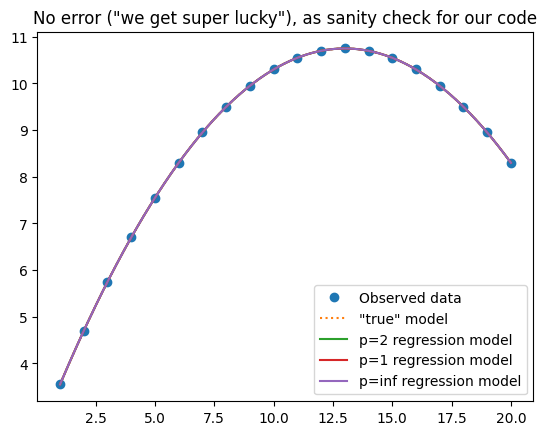

In [ ]:
y   = trueModel(x) + 0  # no noise added


xPlot = np.linspace(a,b,200) # for plotting only
plt.plot(x,y,'o', label='Observed data')
plt.plot(xPlot,trueModel(xPlot),':', label='"true" model')
for p in [2,1,"inf"]:
    poly = lp_regression(x,y,deg,p=p)
    plt.plot(xPlot,poly(xPlot),'-', label=f'p={p} regression model')
plt.legend()
plt.title('No error ("we get super lucky"), as sanity check for our code')
plt.show()

### 1b: Uncorrelated ("white") additive Gaussian noise
We have $y = p(x) + z$ where $z\sim N(0,\sigma^2)$ is a Gaussian/normal "noise" variable

**Task**: using the same $x$ values as above, and the $y$ values provided below, run $\ell_p$ regression for $p=1,2,\infty$ and decide which choice of $p$ makes the most sense. Justify this with a sentence of text. You should make a plot to help arrive at your conclusion.

In [ ]:
sigma = 1
rng   = np.random.default_rng(67)
y     = trueModel(x) + sigma*rng.standard_normal(m)

# ... add your own code below, make a plot, and write a sentence or two about the results

### 1c: Quantization error
Suppose $y = \text{quantize}(p(x))$ where "quantize" means rounding of some sort. This could be rounding to, say, the 5th decimal place. In our example below, we'll make the rounding fairly extreme (round to the nearest even integer) so that the effect is pronounced.

**Task**: using the same $x$ values as before, and the $y$ values provided below, run $\ell_p$ regression for $p=1,2,\infty$ and decide which choice of $p$ makes the most sense. Justify this with a sentence of text. You should make a plot to help arrive at your conclusion.

In [ ]:
y   = np.round( trueModel(x)/2 )*2

# ... add your own code below, make a plot, and write a sentence or two about the results

### 1d Outliers
The $y_1$ entry (if we count starting at the index $0$) should be 4.7. Suppose the data comes from a person typing it in, and they typed in "7.4" rather than "4.7". We call this an "outlier".

**Task**: using the same $x$ values as above, and the $y$ values provided below, run $\ell_p$ regression for $p=1,2,\infty$ and decide which choice of $p$ makes the most sense. Justify this with a sentence of text. You should make a plot to help arrive at your conclusion.

In [ ]:
y   = trueModel(x)
# y[1] is supposed to be 4.7, but suppose we typed it in as a 7.4
y[1] = 7.4

# ... add your own code below, make a plot, and write a sentence or two about the results

### 1e Different weights
Suppose the variance of our noise depends on which $x_i$ variable we're looking at. For example, you and your lab partner take turns collecting data, and you're a much better experimentalist than your lab partner.

Below, we'll use the `std` variable to control the standard deviation of each noise entry.

Do this for **one** choice of $p$, but compare weighted vs unweighted regression. Does weighted regression work significantly better, or is there little difference? (or does it work worse? double-check your implementation)

**Task**: using the same $x$ values as above, the $y$ values provided below, and the correct weights (hint: we want to weight observations with more variance *less* than observations with less variance), run $\ell_p$ regression for a choice of $p$ decide if weighted regression is better or worse than unweighted regression. Justify this with a sentence of text. You should make a plot to help arrive at your conclusion.

In [ ]:
rng = np.random.default_rng(67)
std = np.tile( [.1,5], int(m/2) )
y   = trueModel(x) + std*rng.standard_normal(m)

# ... add your own code below, make a plot, and write a sentence or two about the results
# Given the "std" vector, how should you define your weights vector?


## Part 2: real world data

Task: find any dataset on the internet that you want, and do a regression fit to it. You need to decide:
1. which dataset (and any **transformations** to do, e.g., take the log()??)
2. what degree polynomial to fit
3. what kind of loss: l2 (a good default choice), or something fancier?


If you need ideas of where to browse for a dataset, try:
- [UCI Machine Learning Repository](https://archive.ics.uci.edu/datasets)
- [PyTorch datasets](https://docs.pytorch.org/vision/main/datasets.html)
- [Kaggle datasets](https://www.kaggle.com/datasets)
- [Google dataset search](https://datasetsearch.research.google.com/)
- [Hugging face datasets](https://huggingface.co/docs/datasets/en/index)
- Weather data, since there are many nice python wrappers to download this, e.g., [meteostat-python](https://github.com/meteostat/meteostat-python)
- Financial data, also lots of nice python wrappers. For financial data, does it make sense to take the log() or not?

You're not restricted to time series data, but they are particularly simple since there's a single scalar independent variable (which is the case we've covered), so I recommend them

**Task**: run a regression and create a plot showing the data and the regression curve. Add a sentence or two about your decision making (what degree polynomial? Did you preprocess data? which value of $p=1,2,\infty$ made the most sense?).

In [ ]:
import yfinance as yf # just an example (this is an API for Yahoo Finance)
import pandas as pd

In [ ]:
# ... add your own code below, make a plot, and write a sentence or two about the results

## Part 3: for the ambitious, try Orthogonal Distance Regression
Look into ODR (or it's linear version, [total least squares](https://en.wikipedia.org/wiki/Total_least_squares)) using `scipy.odr`



In [ ]:
# Basic TLS is simple and just requires an SVD. Let's download some code we found on the internet:
!wget -q https://github.com/RyotaBannai/total-least-squares/raw/refs/heads/master/tsl.py
from tsl import tls

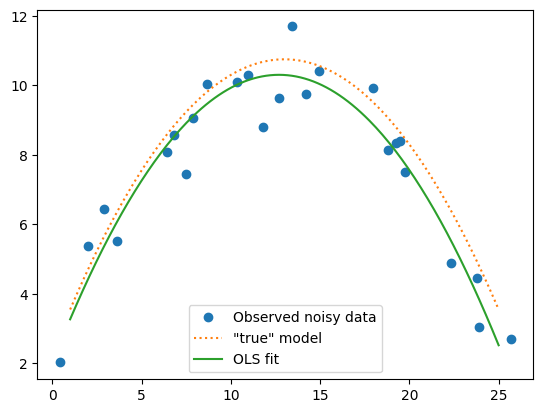

In [ ]:
from scipy import odr
import numpy as np

m   = 25 # number of data points
a, b = 1, m # x domain
x   = np.linspace(a,b,m) # nodes
trueModel = lambda x : 2.3 + 1.3*x - .05*x**2
deg = 2 # we'll try to fit the data with a degree 2 polynomial
rng   = np.random.default_rng(67)

# Error in variables and in responses
xx = x + rng.standard_normal(m)
y = trueModel( xx ) + rng.standard_normal(m)
plt.plot(xx,y,'o', label='Observed noisy data')
xPlot = np.linspace(a,b,200) # for plotting only
plt.plot(xPlot,trueModel(xPlot),':', label='"true" model')

# Re-use our code to give us the Vandermonde matrix
poly, coeff, X, poly_from_coeffs = lp_regression(x,y,deg=2,p=2,debug=True)
plt.plot(xPlot,poly(xPlot),label='OLS fit')


# ... add your own code below, make a plot, and write a sentence or two about the results
# ... Try calling the tls() code (give it your Vandermonde matrix and response y)
# and/or, try the ODR package from scipy, e.g., data = odr.Data(x, y), ...

plt.legend()
plt.show()